## New Simple QNLP Project

## Main Project

In [30]:
from preprocess import normalize_text, tokenize_text, \
                        merge_compound_verbs,label_roles
txt1 = ' ?!!احمد غذا خوشمزه را خورد '
txt2 = 'رضا برنامه را ران گرفت'
txt3 = "مرد برنامه مناسب را اشکالزدایی کرد"
txt1 = normalize_text(txt1)
txt2 = normalize_text(txt2)

tokens1= (tokenize_text(txt1))
tokens2= (tokenize_text(txt2))

print(tokenize_text(txt1))
print(merge_compound_verbs(tokens2))

print(label_roles(tokens1))



['احمد', 'غذا', 'خوشمزه', 'را', 'خورد']
['رضا', 'برنامه', 'را', 'ران_گرفت']
[('احمد', 'subj'), ('غذا', 'obj'), ('خوشمزه', 'adj'), ('را', 'other'), ('خورد', 'verb')]


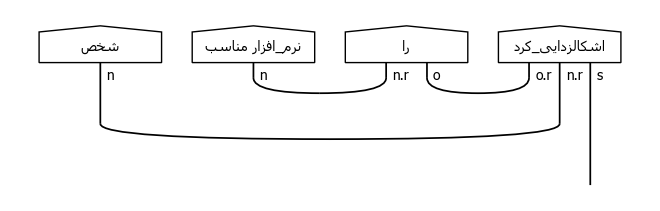

In [16]:
from persian_cat_parser import PersianCatParser
sent1 = "مرد غذا  را پخت"
# sent1 = "مرد ماهر نرم افزار مناسب را اجرا کرد"
sent1 = "مرد برنامه را اشکالزدایی کرد"

parser = PersianCatParser()
sent1 = "شخص نرم افزار مناسب را اشکالزدایی کرد"
diagram = parser.sentence2diagram(sent1)
diagram.draw()


In [18]:
from persian_cat_parser import PersianCatParser
from preprocess import read_data

train_labels, train_data = read_data("datasets/mc_train_data.txt")   # label [t 1-t]
dev_labels, dev_data     = read_data("datasets/mc_dev_data.txt")
test_labels, test_data   = read_data("datasets/mc_test_data.txt")

parser = PersianCatParser(verbose=True)

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams   = parser.sentences2diagrams(dev_data)
raw_test_diagrams  = parser.sentences2diagrams(test_data)

Sentence: زن برنامه را اجرا کرد.


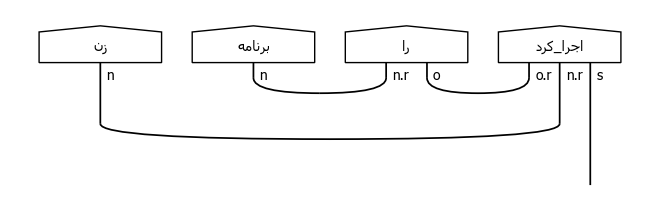

In [19]:
# انتخاب یک جمله و نمایش ان
idx = 35 
sent = train_data[idx]
# sent = "مرد غذای خوشمزه را پخت"

d = parser.sentence2diagram(sent)
print("Sentence:", sent)
# print("Diagram:", d)
d.draw()

### Create Diagram

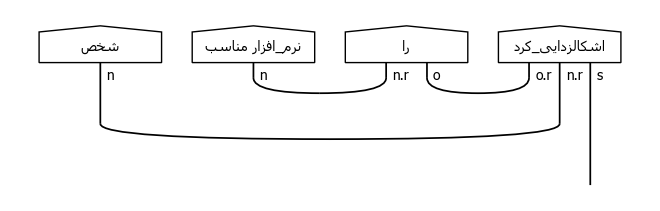

In [20]:
# print(train_data[14])
# raw_train_diagrams[14].draw()
import matplotlib.pyplot as plt
from matplotlib import rcParams

# معرفی فونت فارسی
rcParams['font.family'] = 'Tahoma'   # یا مثلاً 'Vazirmatn' اگر نصب باشه
raw_train_diagrams[29].draw(size='18')
plt.show()

Sentence: زن شام را پخت.


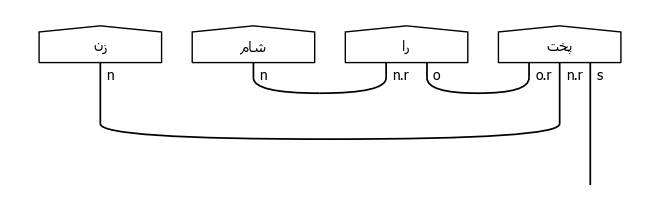

In [21]:
from persian_cat_parser import PersianCatParser
from preprocess import read_data

train_labels, train_data = read_data("datasets/mc_train_data.txt")   # label [t 1-t]
parser = PersianCatParser(verbose=True)
raw_train_diagrams = parser.sentences2diagrams(train_data)
idx = 34 
sent = train_data[idx]
d = parser.sentence2diagram(sent)
print("Sentence:", sent)
d.draw()

### Remove the Cups

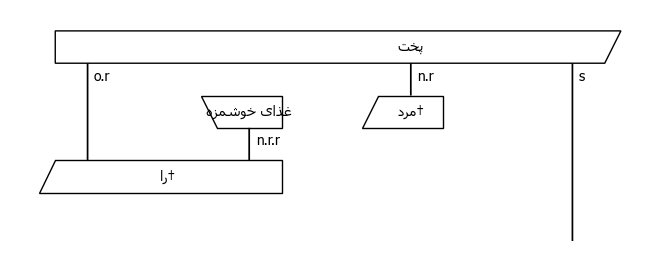

In [22]:
from lambeq import RemoveCupsRewriter
remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams   = [remove_cups(diagram) for diagram in raw_dev_diagrams  ]
test_diagrams  = [remove_cups(diagram) for diagram in raw_test_diagrams ]

train_diagrams[14].draw()

### Create Circuits 

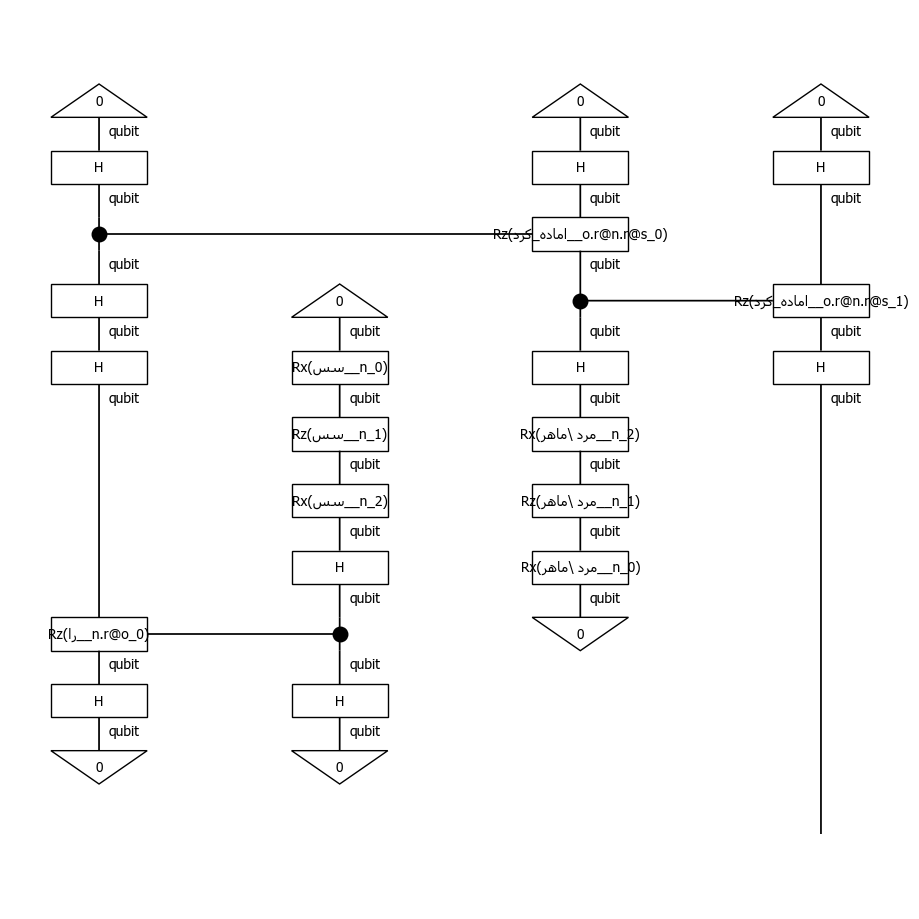

In [23]:
from lambeq import AtomicType, IQPAnsatz
from lambeq.backend.grammar import Cup, Word, Diagram, Id, Swap, Ty

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, Ty('o'):1}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits   = [ansatz(diagram) for diagram in dev_diagrams  ]
test_circuits  = [ansatz(diagram) for diagram in test_diagrams ]

train_circuits[0].draw(figsize=(9, 9))

## the main persian project for ML learning

In [24]:
from persian_cat_parser import PersianCatParser
from preprocess import read_data

train_labels, train_data = read_data("datasets/mc_train_data.txt")   # label [t 1-t]
dev_labels, dev_data     = read_data("datasets/mc_dev_data.txt")
test_labels, test_data   = read_data("datasets/mc_test_data.txt")

parser = PersianCatParser(verbose=True)

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams   = parser.sentences2diagrams(dev_data)
raw_test_diagrams  = parser.sentences2diagrams(test_data)

In [25]:
from lambeq import RemoveCupsRewriter 

remove_cups = RemoveCupsRewriter()
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams   = [remove_cups(diagram) for diagram in raw_dev_diagrams  ]
test_diagrams  = [remove_cups(diagram) for diagram in raw_test_diagrams ]

In [26]:
from lambeq import IQPAnsatz
from lambeq import AtomicType
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, Ty('o'):1}, n_layers=1, n_single_qubit_params=3)
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits   = [ansatz(diagram) for diagram in dev_diagrams  ]
test_circuits  = [ansatz(diagram) for diagram in test_diagrams ]

In [27]:
# -------------------------------
# Backend and model
# -------------------------------
from lambeq import TketModel
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
all_circuits = train_circuits + dev_circuits + test_circuits
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [28]:
# -------------------------------
# Training setup
# -------------------------------
from lambeq import BinaryCrossEntropyLoss
from lambeq import QuantumTrainer, SPSAOptimizer
import numpy as np

bce = BinaryCrossEntropyLoss()
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2

BATCH_SIZE = 30
EPOCHS = 140

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A': 0.01 * EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=2,
)

In [7]:
# -------------------------------
# Prepare datasets
# -------------------------------
from lambeq import Dataset
train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset   = Dataset(dev_circuits, dev_labels, shuffle=False)

# Train
trainer.fit(train_dataset, val_dataset, log_interval=1)

Epoch 1:    train/loss: 1.9313   valid/loss: 0.7920   train/time: 28.24s   valid/time: 7.86s   train/acc: 0.4718   valid/acc: 0.5333
Epoch 2:    train/loss: 0.8232   valid/loss: 0.8414   train/time: 27.69s   valid/time: 5.53s   train/acc: 0.5211   valid/acc: 0.5500
Epoch 3:    train/loss: 0.7751   valid/loss: 1.4953   train/time: 27.60s   valid/time: 5.71s   train/acc: 0.6056   valid/acc: 0.5000
Epoch 4:    train/loss: 1.7915   valid/loss: 0.9706   train/time: 28.00s   valid/time: 5.49s   train/acc: 0.5070   valid/acc: 0.4667
Epoch 5:    train/loss: 0.8167   valid/loss: 0.6993   train/time: 27.69s   valid/time: 5.65s   train/acc: 0.5000   valid/acc: 0.6333
Epoch 6:    train/loss: 1.6721   valid/loss: 0.8375   train/time: 27.61s   valid/time: 5.95s   train/acc: 0.5282   valid/acc: 0.5667
Epoch 7:    train/loss: 1.9616   valid/loss: 1.1423   train/time: 28.11s   valid/time: 5.58s   train/acc: 0.4859   valid/acc: 0.4000
Epoch 8:    train/loss: 2.1859   valid/loss: 1.0612   train/time: 26.

In [9]:
test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

Test accuracy: 0.36666666666666664


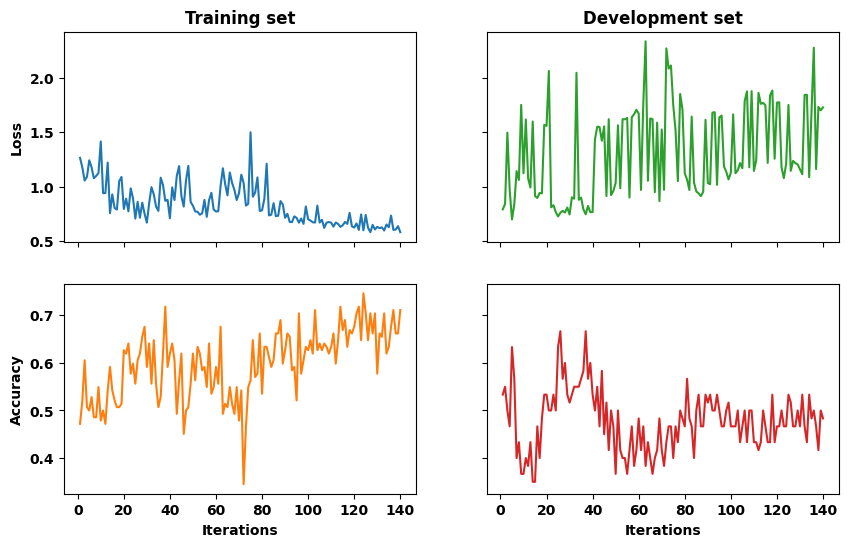

In [10]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))


In [11]:
# -------------------------------
# Example: classify a new sentence
# -------------------------------
label_map = {0: "Food Class", 1: "IT Class"}
new_sentence = ["زن غذا را خورد"]   # safer than "He runs the code"

# Parse and simplify
new_diagram = remove_cups(parser.sentence2diagram(new_sentence[0]))

# Diagram -> circuit
new_circuit = ansatz(new_diagram)

# Prediction
prediction = model([new_circuit])
predicted_class = np.argmax(prediction, axis=1)[0]

print("Sentence:", new_sentence[0])
print("Prediction (raw):", prediction)
print("Predicted class:", label_map[predicted_class])

Sentence: زن غذا را خورد
Prediction (raw): [[0.31851852 0.68148148]]
Predicted class: IT Class


In [14]:
index=23
print(test_data[index])
print("\n")
print(model([test_circuits[index]]))
print("\n")
print(f"The Class is assigned to : {np.argmax(model([test_circuits[index]]))}")
print(f"The True Class Label is : {int(np.argmax(test_labels[index]))}")   # for food label is 1 so --> [1 0]

print("Label=0 is for Food class and Label=1 is for IT class")


حسین مرورگر را اجرا کرد


[[0.74698795 0.25301205]]


The Class is assigned to : 0
The True Class Label is : 1
Label=0 is for Food class and Label=1 is for IT class


In [42]:
labels, sentences = read_data("datasets/mc_test_data.txt")
for i in range(5):
    print(sentences[i], labels[i])

سارا لپ‌تاپ را روشن کرد [0, 1]
نرگس برنج را دم کرد [1, 0]
مریم پوشه را پاک کرد [0, 1]
امید سالاد را خورد [1, 0]
مریم پرینتر را پیکربندی کرد [0, 1]


In [97]:
new_sentence = ["person debugs software ."]

# Parse
new_diagram = parser.sentence2diagram(new_sentence[0])
new_diagram = remove_cups(new_diagram)

# Convert to circuit
new_circuit = ansatz(new_diagram)

# Run through trained model
prediction = model([new_circuit])
print("Raw output:", prediction)

# Get predicted label
predicted_class = np.argmax(prediction, axis=1)[0]
print("Predicted class:", predicted_class)


Raw output: [[0.09943182 0.90056818]]
Predicted class: 1


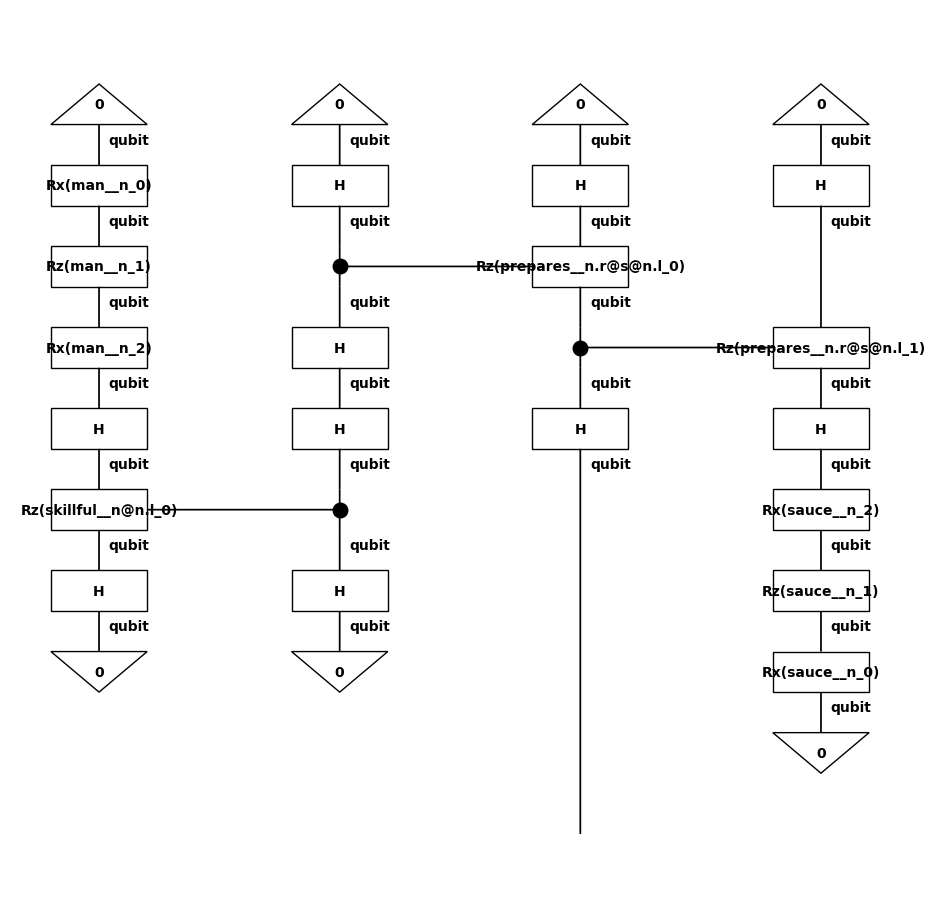

In [77]:
# train_circuits[50].draw(figsize=(9, 9))
# tket_circuit = train_circuits[0].to_tk()
# train_circuits

# from pytket.circuit.display import render_circuit_jupyter, view_browser,render_circuit_as_html

# #render_circuit_jupyter(tket_circuit)
# 
# render_circuit_as_html(tket_circuit)
# train_circuits[0]
train_circuits[0].draw(figsize=(9, 9))